# OPAN 6609 - Text Analytics
## Final Project

**SAXA 3**
Mike Johnson | Kris Lederer | Sebastian Martinez | Ryan Mathis | Khushi Patel

****

### Set up

In [1]:
# Import libraries

# Data manipulation
import pandas as pd
import numpy as np

# Stats
from scipy import stats

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Text Analysis
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Load data
df = pd.read_csv('hotel_final.csv', index_col = 'reviewID')

df = df.drop(columns = 'Unnamed: 0')

df.head()

,reviewContent,rating,usefulCount,coolCount,funnyCount
reviewID,,,,,
-ZkzDLAp-6LSdek-nU,My husband took me to stay the night for a fun...,4,0,0,0
9yStfyRS5CISu-May43dmA,"stayed at the property over the weekend, got a...",3,0,0,0
Wf-7bJszS2n6REXGbrwK2w,"Overall, I think I'm less and less a fan of th...",3,0,0,0
ZLe,I'd like to make a confession. I don't really ...,3,21,11,16
vURf9AGmThDrRC9TVcQrdw,The good: the view; location The bad: servic...,1,0,0,0


****

### Exploratory Analysis

#### Descriptive Statistics

In [3]:
# Descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,949.0,3.480506,1.199019,1.0,3.0,4.0,4.0,5.0
usefulCount,949.0,0.896733,1.753802,0.0,0.0,0.0,1.0,21.0
coolCount,949.0,0.473130,1.285494,0.0,0.0,0.0,0.0,20.0
funnyCount,949.0,0.378293,1.159802,0.0,0.0,0.0,0.0,16.0


#### Positive vs Negative Ratings

Let's understand the proportion of a positive and negative ratings. For this exercise, categorize ratings into these buckets based on the rating. How we define the categories in `rating_dict`.

In [4]:
# Define positive, negative, neutral conditions
rating_dict = {1: "Negative",
               2: "Negative",
               3: "Mixed",
               4: "Positive",
               5: "Positive"}

# Map rating_dict to df
df['rating_category'] = df['rating'].map(rating_dict)

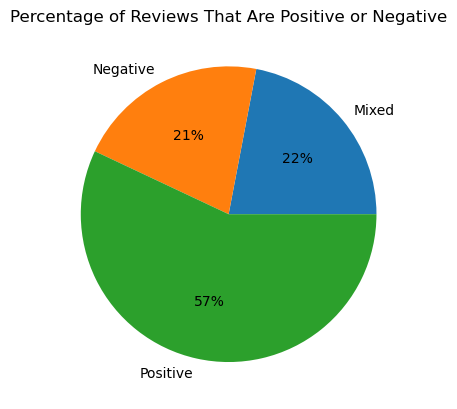

In [5]:
# Summary table rating category
rating_pos_neg = df.groupby(['rating_category']).size().reset_index(name = 'count')
rating_pos_neg['percent_total'] = (rating_pos_neg['count'] / rating_pos_neg['count'].sum()).round(2)

# Visualize Results
plt.pie(rating_pos_neg['percent_total'], labels = rating_pos_neg['rating_category'], autopct = '%1.f%%')
plt.title('Percentage of Reviews That Are Positive or Negative')
plt.show()

### N-Grams

Let's take a look at the n-grams to see if there are any noticeable high frequency terms.

In [6]:
# Define function to get top n-grams
def top_ngrams(dataframe, text_column, ngram_range=(1,1), additional_stop_words = [], top_n=10):
    """
    Four arguments:
    1. dataframe - input DataFrame
    2. text_column - name of text column  
    3. ngram_range - tuple (min, max) for n-gram range
    4. additional_stop_words - list of any stop words that need to added to the standard stop words list.
    5. top_n - number of top results
    """
    # Extract text from dataframe column
    text_data = dataframe[text_column].tolist()

    # Apply Contraction Expansion
    #text_data = [contractions.fix(text) for text in text_data]

    # Stop words
    combined_stop_words = list(ENGLISH_STOP_WORDS.union(set(additional_stop_words)))
    
    # Instantiate vectorizer
    vectorizer = CountVectorizer(
        ngram_range = ngram_range,
        stop_words = combined_stop_words,
    )
    
    # Vectorize, convert to dense, sum frequencies, sort
    sparse_matrix = vectorizer.fit_transform(text_data)
    dense_matrix = sparse_matrix.toarray()

    # Get feature names (n-grams)
    feature_names = vectorizer.get_feature_names_out()
   
    # Sum the frequencies of the terms across all documents
    term_frequencies = np.sum(dense_matrix, axis=0)

    # Create dataframe with terms and frequencies
    df_ngrams = pd.DataFrame({
        'term': feature_names,
        'frequency': term_frequencies
    })

    # Sort the results by the count (frequency) in descending order
    df_ngrams = df_ngrams.sort_values('frequency', ascending=False)

    # Keep only the top n number of results (n is 10 by default but can be adjusted)
    df_ngrams = df_ngrams.head(top_n)
   
    return df_ngrams

In [7]:
# Define function for n-grams visualization
def ngrams_viz(dataframe, text_column, ngram_range=(1,1), additional_stop_words = [], top_n=10):
    """
    Helpful function for visualizing positive vs negative n-grams.
    Uses top_ngrams() to get the data.

    Four arguments:
    1. dataframe - input DataFrame
    2. text_column - name of text column  
    3. ngram_range - tuple (min, max) for n-gram range
    4. additional_stop_words - list of any stop words that need to added to the standard stop words list.
    5. top_n - number of top results
    """

    # Get positive reviews
    df_positive = top_ngrams(dataframe[dataframe['rating_category'] == 'Positive'], text_column, ngram_range, additional_stop_words, top_n)

    # Get positive reviews
    df_mixed = top_ngrams(dataframe[dataframe['rating_category'] == 'Mixed'], text_column, ngram_range, additional_stop_words, top_n)   

    # Get negative reviews
    df_negative = top_ngrams(dataframe[dataframe['rating_category'] == 'Negative'], text_column, ngram_range, additional_stop_words, top_n)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Visualize positive n-grams on the first subplot (axes[0])
    sns.barplot(x = "frequency", 
                y = "term", 
                data = df_positive,
                ax = axes[0])
    axes[0].set_title(f'Top {top_n} {ngram_range} N-Grams in Positive Reviews')
    axes[0].set_ylabel(f'N-Gram (Range: {ngram_range})')

    # Visualize mixed n-grams on the second subplot (axes[1])
    sns.barplot(x = "frequency", 
                y = "term", 
                data = df_mixed,
                ax = axes[1])
    axes[1].set_title(f'Top {top_n} {ngram_range} N-Grams in Mixed Reviews')
    axes[1].set_ylabel(f'N-Gram (Range: {ngram_range})')   

    # Visualize negative n-grams on the third subplot (axes[2])
    sns.barplot(x = "frequency", 
                y = "term", 
                data = df_negative,
                ax = axes[2])
    axes[2].set_title(f'Top {top_n} {ngram_range} N-Grams in Negative Reviews')
    axes[2].set_ylabel(f'N-Gram (Range: {ngram_range})')

    # Display plot
    plt.tight_layout()
    plt.show()



#### Initial Pass

**Unigrams**

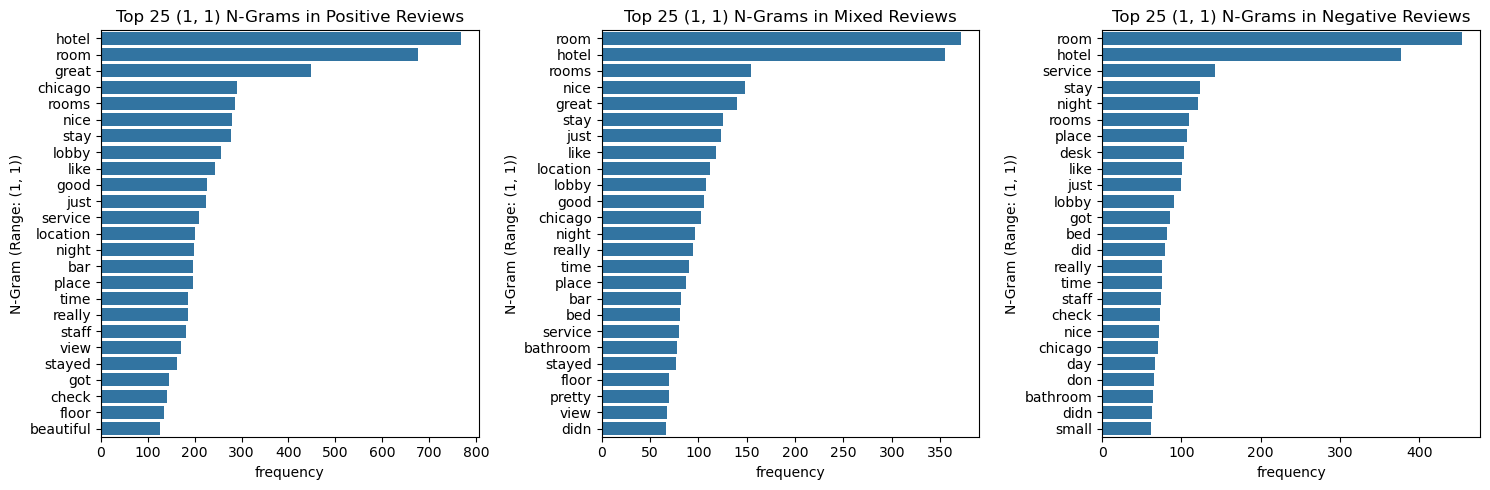

In [8]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (1,1), 
    additional_stop_words = [],
    top_n = 25)

**Bigrams**

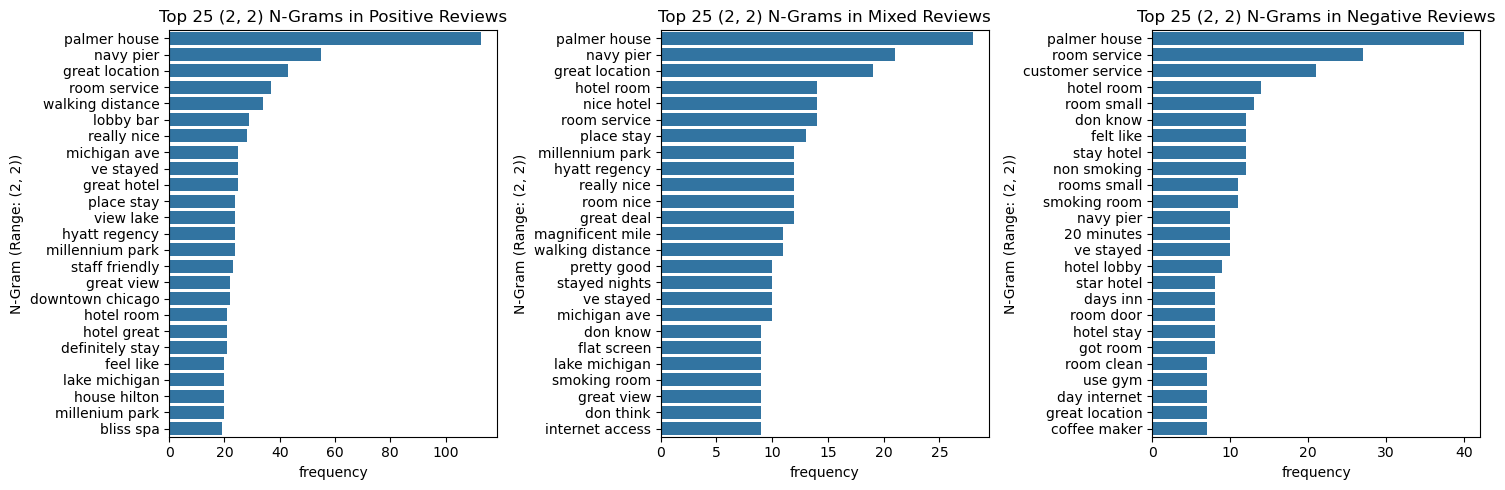

In [9]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (2,2), 
    additional_stop_words = [],
    top_n = 25)

**Trigrams**

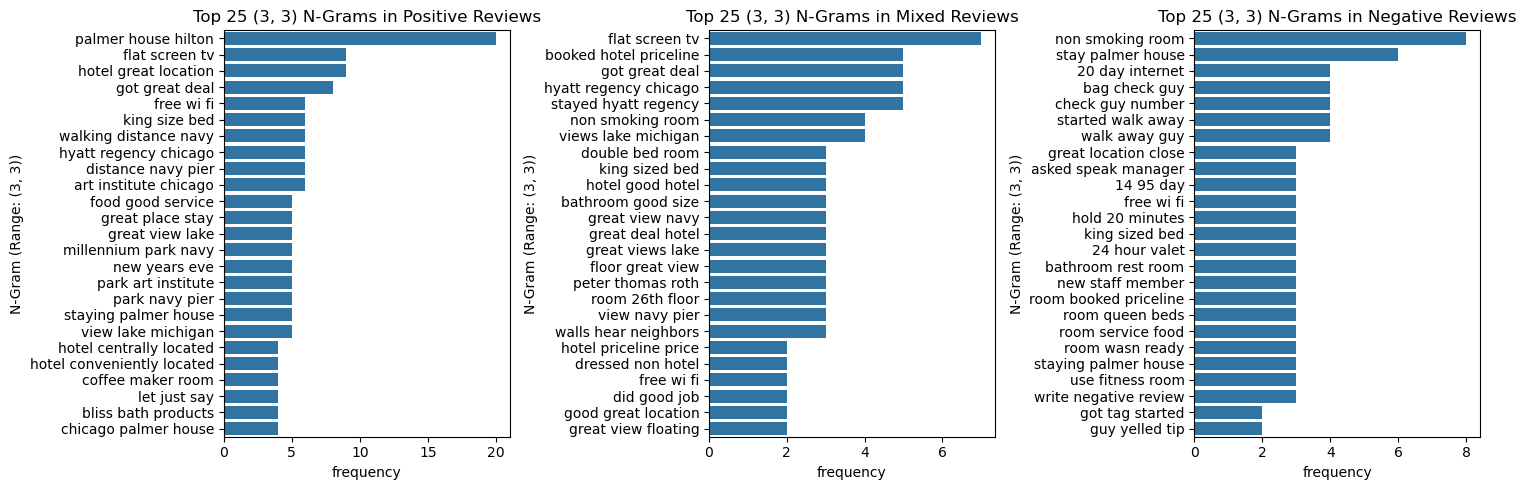

In [10]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (3,3), 
    additional_stop_words = [],
    top_n = 25)

**Takeaways**
* Bigrams appears to capture themes best
* Stop words need to be added to remove noise

#### Revised pass with additional stop words

* Remove Chicago.
* Remove Hotel Names. Reviews appear to be for two hotels after further review. Removing the names for both.
* Remove hotel
* Remove miscellaneous stop words

In [11]:
# Define stop words
custom_stop_words = ['chicago', 
                     'palmer', 
                     'house', 
                     'hilton', 
                     'hyatt', 
                     'regency',
                     'days',
                     'inn', 
                     'hotel', 
                     'just', 
                     've', 
                     'don', 
                     'navy', 
                     'pier', 
                     'millenium', 
                     'park',
                     'michigan',
                     'ave',
                     'art',
                     'institute'
                     ]

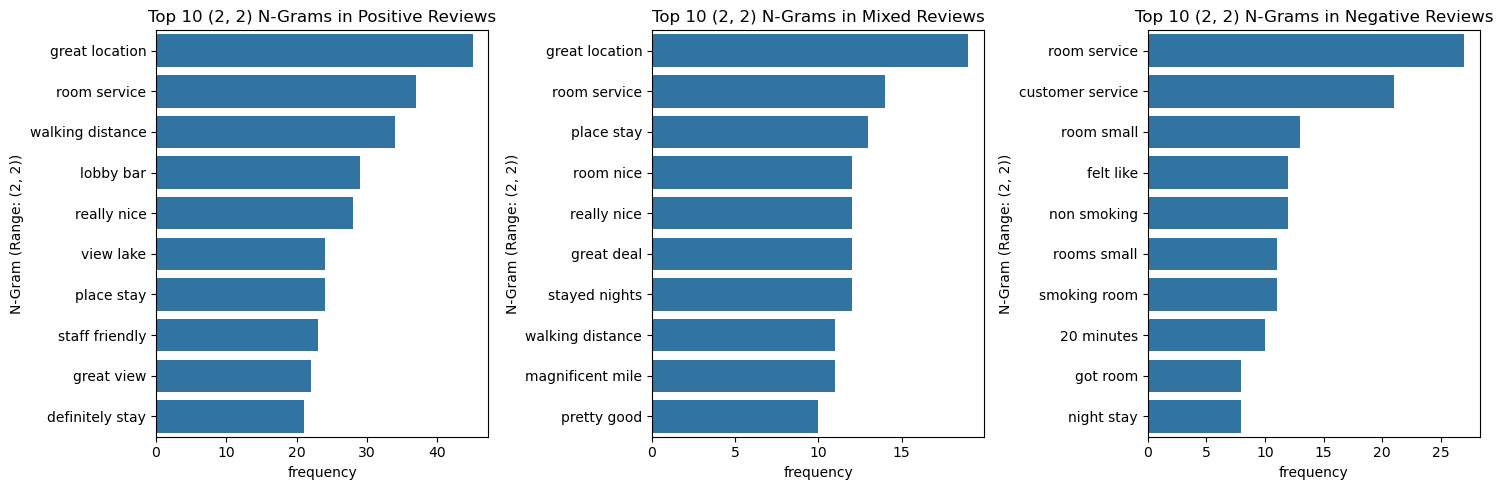

In [12]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (2,2), 
    additional_stop_words = custom_stop_words,
    top_n = 10)

The bigrams suggest that the hotel's key strength is its location. The positive and mixed reviews make reference to *great location* and *walking distance*.

Other observations:
* Mixed reviews top bigrams appear to lean more positive.
* Negative reviews suggest *customer service*, *room size* and *smoking* are key areas of frustration.
* Inconsistency in *room service* experience with the bigram appearing in both frequently.

### Latent Dirichlet Allocation (LDA) Set up

In [13]:
# Stop words
combined_stop_words = list(ENGLISH_STOP_WORDS.union(set(custom_stop_words)))

In [14]:
# Create TF-IDF vectors for topic modeling
vectorizer = CountVectorizer(
    #max_features = 1000,
    max_df = 0.95,
    min_df = 5,
    stop_words = combined_stop_words,
    ngram_range = (2,2)
)

vectorizer_matrix = vectorizer.fit_transform(df['reviewContent'])
feature_names = vectorizer.get_feature_names_out()

print(f"Matrix Shape: {vectorizer_matrix.shape}")
print(f"Number of features (terms): {len(feature_names)}")

Matrix Shape: (949, 705)
Number of features (terms): 705


In [15]:
# Define function to fit LDA model
def lda_fit(
    dataframe, 
    text_column,  
    n_topics = 2  
):
    """
    Function fits LDA model
    
    Three arguments:
    1. dataframe - input DataFrame
    2. text_column - name of text column  
    3. n_topics - number of topics
    """

    vec = vectorizer.transform(dataframe[text_column])

    # Instantiate LDA model
    lda_model = LatentDirichletAllocation(
        n_components = n_topics,
        max_iter = 50,
        learning_method = 'online',
        random_state = 206,
        n_jobs = -1
    )

    # Fit LDA Model
    lda_output = lda_model.fit_transform(vec)
    
    return lda_model, lda_output
    

In [16]:
# Define function to display topics
def display_topics(model, feature_names, n_top_words=10):
    """Display top words for each topic"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
        print(f"\nTopic {topic_idx + 1}:")
        print(", ".join(top_words))
    return topics

In [17]:
# Define function for assigning a dominant topic to a review
def assign_topic(dataframe, lda_output):
    """Assigns each review a dominant topic and topic probability"""

    dataframe['dominant_topic'] = lda_output.argmax(axis=1)+1
    dataframe['topic_probability'] = lda_output.max(axis=1).round(2)

    return dataframe

### What topics do reviewers tend to bring up in general?

In [18]:
# Fit LDA to all data
lda_all = lda_fit(dataframe = df,
                  text_column = 'reviewContent',
                  n_topics = 4)

display_topics(model = lda_all[0],
               feature_names = feature_names,
               n_top_words = 5)


Topic 1:
stayed nights, wi fi, felt like, smoking room, place stay

Topic 2:
feel like, highly recommend, make sure, late check, block away

Topic 3:
customer service, great location, staff friendly, room clean, got room

Topic 4:
room service, rooms small, room small, definitely stay, great deal


[['stayed nights', 'wi fi', 'felt like', 'smoking room', 'place stay'],
 ['feel like', 'highly recommend', 'make sure', 'late check', 'block away'],
 ['customer service',
  'great location',
  'staff friendly',
  'room clean',
  'got room'],
 ['room service',
  'rooms small',
  'room small',
  'definitely stay',
  'great deal']]

In [19]:
# Topic mappings
topics_all_dict = {
    1: "Wifi, Smoking",
    2: "Highly Recommend, Late, Location",
    3: "Customer Service, Clean Rooms, Location",
    4: "Room Service, Small Rooms, Deal"
}



In [20]:
# Apply topics to data frame for analysis
df_topics_all = assign_topic(df, lda_all[1])

# Map topics dictionary
df_topics_all['topic_name'] = df_topics_all['dominant_topic'].map(topics_all_dict)

df_topics_all

,reviewContent,rating,usefulCount,coolCount,funnyCount,rating_category,dominant_topic,topic_probability,topic_name
reviewID,,,,,,,,,
-ZkzDLAp-6LSdek-nU,My husband took me to stay the night for a fun...,4,0,0,0,Positive,4,0.88,"Room Service, Small Rooms, Deal"
9yStfyRS5CISu-May43dmA,"stayed at the property over the weekend, got a...",3,0,0,0,Mixed,2,0.95,"Highly Recommend, Late, Location"
Wf-7bJszS2n6REXGbrwK2w,"Overall, I think I'm less and less a fan of th...",3,0,0,0,Mixed,3,0.80,"Customer Service, Clean Rooms, Location"
ZLe,I'd like to make a confession. I don't really ...,3,21,11,16,Mixed,1,0.95,"Wifi, Smoking"
vURf9AGmThDrRC9TVcQrdw,The good: the view; location The bad: servic...,1,0,0,0,Negative,3,0.42,"Customer Service, Clean Rooms, Location"
...,...,...,...,...,...,...,...,...,...
_xRi_iGcxGf6dX1F_mmyyQ,Out stay at the W chicago was amazing..they ha...,4,2,0,0,Positive,3,0.85,"Customer Service, Clean Rooms, Location"
6_TJOoDQwOYRBlsqu6SoaQ,I stayed at this hotel back in March for a lon...,4,1,1,1,Positive,3,0.57,"Customer Service, Clean Rooms, Location"
_5mDKj1Q91zlnEEjeEIvtg,I came here a couple years ago for a romantic ...,5,1,1,0,Positive,3,0.89,"Customer Service, Clean Rooms, Location"


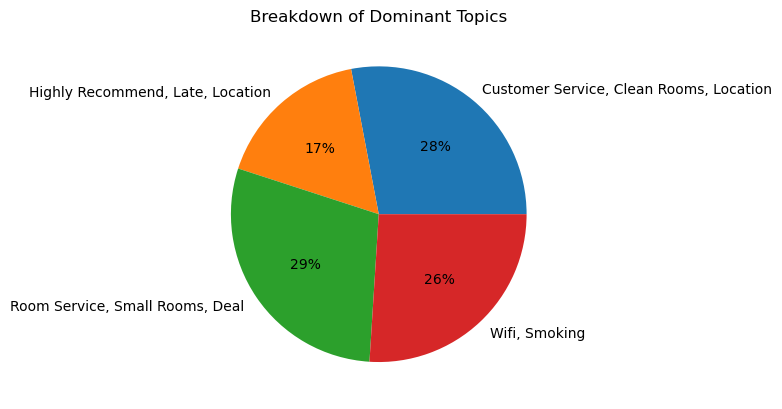

In [21]:
# Summary table rating category
dominant_topic_all = df_topics_all.groupby(['topic_name']).size().reset_index(name = 'count')
dominant_topic_all['percent_total'] = (dominant_topic_all['count'] / dominant_topic_all['count'].sum()).round(2)

# Visualize Results
plt.pie(dominant_topic_all['percent_total'], labels = dominant_topic_all['topic_name'], autopct = '%1.f%%')
plt.title('Breakdown of Dominant Topics')
plt.show()

### How do happy customers differ from unhappy customers in the topics they bring up in their review? 

In [22]:
# Data frame filtered to 'happy' customers
df_happy = df[df['rating_category'] == 'Positive'].copy()

# Data frame filtered to 'unhappy' customers
df_unhappy = df[df['rating_category'] == 'Negative'].copy()

#### Happy Customers

In [23]:
# Fit LDA to happy customer data
lda_happy = lda_fit(dataframe = df_happy ,
                  text_column = 'reviewContent',
                  n_topics = 4)

display_topics(model = lda_happy[0],
               feature_names = feature_names,
               n_top_words = 5)


Topic 1:
great place, place stay, hotels city, great service, really nice

Topic 2:
room service, bliss spa, room pretty, view lake, love love

Topic 3:
great location, staff friendly, lobby bar, owner comment, room clean

Topic 4:
great deal, rooms nice, staff great, lobby area, great location


[['great place', 'place stay', 'hotels city', 'great service', 'really nice'],
 ['room service', 'bliss spa', 'room pretty', 'view lake', 'love love'],
 ['great location',
  'staff friendly',
  'lobby bar',
  'owner comment',
  'room clean'],
 ['great deal', 'rooms nice', 'staff great', 'lobby area', 'great location']]

In [24]:
# Topic mappings
topics_happy_dict = {
    1: "Great Place, Great Service",
    2: "Room Service, Bliss Spa, Lake View",
    3: "Location, Staff, Lobby Bar, Clean",
    4: "Deal, Rooms, Staff, Location"
}

In [25]:
# Apply topics to data frame for analysis
df_topics_happy = assign_topic(df_happy, lda_happy[1])

# Map topics dictionary
df_topics_happy['topic_name'] = df_topics_happy['dominant_topic'].map(topics_happy_dict)

df_topics_happy

,reviewContent,rating,usefulCount,coolCount,funnyCount,rating_category,dominant_topic,topic_probability,topic_name
reviewID,,,,,,,,,
-ZkzDLAp-6LSdek-nU,My husband took me to stay the night for a fun...,4,0,0,0,Positive,4,0.95,"Deal, Rooms, Staff, Location"
NwZ6u5xqXJGfPNHeKFJVhQ,"Great service, beautiful hotel and rooms! The ...",4,0,0,0,Positive,1,0.81,"Great Place, Great Service"
E1j78xcwMYnymNRlfse-EQ,You cannot go wrong with a W Hotel. It is styl...,4,2,0,0,Positive,3,0.90,"Location, Staff, Lobby Bar, Clean"
40gDUe2eVedqCXqDS8cnmA,Amazing views and location. The room was nice...,4,0,0,0,Positive,1,0.90,"Great Place, Great Service"
0z6LXr8NFM6Cph1T4,Just what you expect from the W. Good customer...,5,0,0,0,Positive,3,0.85,"Location, Staff, Lobby Bar, Clean"
...,...,...,...,...,...,...,...,...,...
r_mo5_LXsnSHjArPHEeZBg,holy CRAP parking is 53 dollars per night!!! o...,4,0,0,0,Positive,3,0.62,"Location, Staff, Lobby Bar, Clean"
_xRi_iGcxGf6dX1F_mmyyQ,Out stay at the W chicago was amazing..they ha...,4,2,0,0,Positive,4,0.65,"Deal, Rooms, Staff, Location"
6_TJOoDQwOYRBlsqu6SoaQ,I stayed at this hotel back in March for a lon...,4,1,1,1,Positive,3,0.72,"Location, Staff, Lobby Bar, Clean"


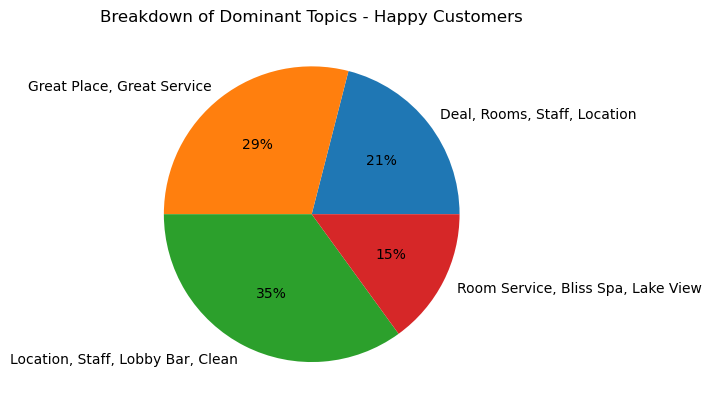

In [26]:
# Summary table rating category
dominant_topic_happy = df_topics_happy.groupby(['topic_name']).size().reset_index(name = 'count')
dominant_topic_happy['percent_total'] = (dominant_topic_happy['count'] / dominant_topic_happy['count'].sum()).round(2)

# Visualize Results
plt.pie(dominant_topic_happy['percent_total'], labels = dominant_topic_happy['topic_name'], autopct = '%1.f%%')
plt.title('Breakdown of Dominant Topics - Happy Customers')
plt.show()

#### Unhappy Customers

In [27]:
# Fit LDA to happy customer data
lda_unhappy = lda_fit(dataframe = df_unhappy ,
                      text_column = 'reviewContent',
                      n_topics = 4)

display_topics(model = lda_unhappy[0],
               feature_names = feature_names,
               n_top_words = 5)


Topic 1:
room service, non smoking, rooms small, room small, smoking room

Topic 2:
coffee maker, room service, night stay, wireless internet, feel like

Topic 3:
customer service, cleaning staff, 30 minutes, credit card, clean room

Topic 4:
felt like, room wasn, maid service, wasn ready, size bed


[['room service', 'non smoking', 'rooms small', 'room small', 'smoking room'],
 ['coffee maker',
  'room service',
  'night stay',
  'wireless internet',
  'feel like'],
 ['customer service',
  'cleaning staff',
  '30 minutes',
  'credit card',
  'clean room'],
 ['felt like', 'room wasn', 'maid service', 'wasn ready', 'size bed']]

In [28]:
# Topic mappings
topics_unhappy_dict = {
    1: "Room Service, Small Rooms, Smoking",
    2: "Room Service, Wifi",
    3: "Customer Service, Cleaning",
    4: "Rooms Not Ready, Maid Service, Bed Size"
}

In [29]:
# Apply topics to data frame for analysis
df_topics_unhappy = assign_topic(df_unhappy, lda_unhappy[1])

# Map topics dictionary
df_topics_unhappy['topic_name'] = df_topics_unhappy['dominant_topic'].map(topics_unhappy_dict)

df_topics_unhappy

,reviewContent,rating,usefulCount,coolCount,funnyCount,rating_category,dominant_topic,topic_probability,topic_name
reviewID,,,,,,,,,
vURf9AGmThDrRC9TVcQrdw,The good: the view; location The bad: servic...,1,0,0,0,Negative,4,0.75,"Rooms Not Ready, Maid Service, Bed Size"
KZPXFD-Db0XGgVta97Nzrg,The location and the atmosphere of the hotel i...,1,0,0,0,Negative,4,0.85,"Rooms Not Ready, Maid Service, Bed Size"
QyZQpwn6t31pOg9SSyO13Q,First time staying @ a W and if they are all l...,2,2,0,0,Negative,2,0.93,"Room Service, Wifi"
MhW8UbJHOkLJrm9hvCkAZQ,Was truly disapointed!! it has GREAT lake vie...,2,0,0,0,Negative,3,0.75,"Customer Service, Cleaning"
VSRoLj0,Pros - View of Lake Michigan - Food was solid ...,2,1,0,0,Negative,4,0.91,"Rooms Not Ready, Maid Service, Bed Size"
...,...,...,...,...,...,...,...,...,...
_0R-JDll512EZadVlFVrwA,Super small rooms but a really beautiful histo...,2,1,0,0,Negative,2,0.92,"Room Service, Wifi"
A_9Vy9CLtBFRz7TmppQ8AA,I travel a lot for work and The Palmer House i...,1,2,0,0,Negative,1,0.75,"Room Service, Small Rooms, Smoking"
_kjw9z8nUx6iCvSsqc_31g,I cannot believe anybody would give this hotel...,1,0,0,0,Negative,4,0.76,"Rooms Not Ready, Maid Service, Bed Size"


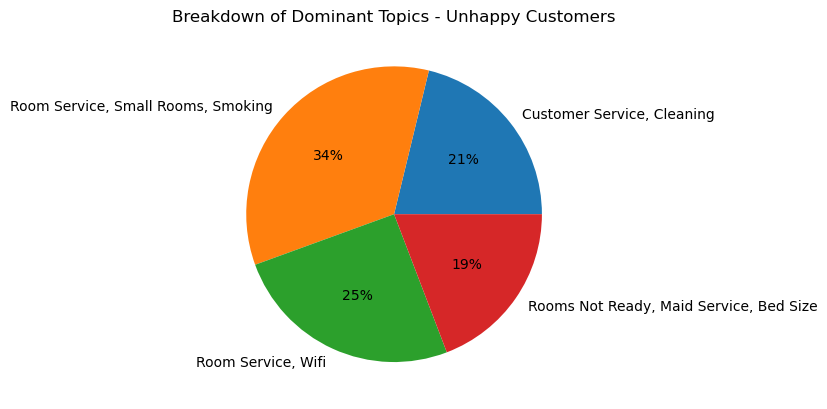

In [30]:
# Summary table rating category
dominant_topic_unhappy = df_topics_unhappy.groupby(['topic_name']).size().reset_index(name = 'count')
dominant_topic_unhappy['percent_total'] = (dominant_topic_unhappy['count'] / dominant_topic_unhappy['count'].sum()).round(2)

# Visualize Results
plt.pie(dominant_topic_unhappy['percent_total'], labels = dominant_topic_unhappy['topic_name'], autopct = '%1.f%%')
plt.title('Breakdown of Dominant Topics - Unhappy Customers')
plt.show()

### Are there other characteristics about customers that would be useful to know about?

In [31]:
# Add 'text_length' column
df_happy['text_length'] = df_happy['reviewContent'].str.len()
df_unhappy['text_length'] = df_unhappy['reviewContent'].str.len()

# Calc Averages
avg_review_length_happy = round(df_happy['text_length'].mean())
avg_review_length_unhappy = round(df_unhappy['text_length'].mean())

# Calc difference
review_length_dif = round((avg_review_length_unhappy - avg_review_length_happy) / avg_review_length_happy, 3)

print(f"Average length of review from happy customers: {avg_review_length_happy}")
print(f"Average length of review from unhappy customers: {avg_review_length_unhappy}")

if review_length_dif > 0:
    print(f"Unhappy reviews are {review_length_dif * 100}% longer than happy reviews on average.")
else:
    print(f"Unhappy reviews are {-review_length_dif * 100}% shorter than happy reviews on average.")

Average length of review from happy customers: 770
Average length of review from unhappy customers: 1074
Unhappy reviews are 39.5% longer than happy reviews on average.


In [32]:
# Evaluate the engagement between positive and negative reviews

# Add 'total_engagement' column
df_happy['total_engagement'] = df_happy['usefulCount'] + df_happy['coolCount'] + df_happy['funnyCount']
df_unhappy['total_engagement'] = df_unhappy['usefulCount'] + df_unhappy['coolCount'] + df_unhappy['funnyCount']

# Calc Averages
avg_engagement_happy = round(df_happy['total_engagement'].mean(), 2)
avg_engagement_unhappy = round(df_unhappy['total_engagement'].mean(), 2)

# Calc difference
review_engagement_dif = round((avg_engagement_unhappy - avg_engagement_happy) / avg_engagement_happy, 3)

print(f"Average engagement of review from happy customers: {avg_engagement_happy}")
print(f"Average engagement of review from unhappy customers: {avg_engagement_unhappy}")

if review_engagement_dif > 0:
    print(f"Unhappy reviews have {review_engagement_dif * 100}% more engagement than happy reviews.")
else:
    print(f"Unhappy reviews have {-review_engagement_dif * 100}% less engagement than happy reviews on average.")


Average engagement of review from happy customers: 1.82
Average engagement of review from unhappy customers: 1.71
Unhappy reviews have 6.0% less engagement than happy reviews on average.


In [33]:
# Summarize engagement stats
comparison_stats = pd.DataFrame({
    'Positive Reviews': [
        len(df_happy),
        df_happy['usefulCount'].mean(),
        df_happy['coolCount'].mean(),
        df_happy['funnyCount'].mean(),
        df_happy['total_engagement'].mean(),
        df_happy['total_engagement'].median()
    ],
    'Negative Reviews': [
        len(df_unhappy),
        df_unhappy['usefulCount'].mean(),
        df_unhappy['coolCount'].mean(),
        df_unhappy['funnyCount'].mean(),
        df_unhappy['total_engagement'].mean(),
        df_unhappy['total_engagement'].median()
    ]
}, index=['Number of Reviews', 'Avg Useful Votes', 'Avg Cool Votes', 
          'Avg Funny Votes', 'Avg Total Engagement', 'Median Total Engagement'])

comparison_stats.round(2)

,Positive Reviews,Negative Reviews
Number of Reviews,540.00,202.00
Avg Useful Votes,0.90,1.00
Avg Cool Votes,0.59,0.27
Avg Funny Votes,0.33,0.44
Avg Total Engagement,1.82,1.71
Median Total Engagement,0.00,1.00


Takeaways:
* Unhappy customers will typically write longer reviews compared to happy customers.
* Potential customers engage more with the positive reviews. 
* How potential customers engage with reviews differ between positive and negative reviews.

### Based on the results and what should your new hotel focus on?

**Short Term**:
* Evaluate room service operations and address bottlenecks.
* Evaluate room cleaning operations, address bottlenecks, establish cleaning standards. 
* Establish customer service standards.
* Implement a strict 'Do Not Disturb' policy.
* Implement a no smoking policy in hotel rooms.

**Long Term**:
* Consider offering free internet service.
* Engage with an interior designer to explore options to make rooms 'feel bigger'.

### What are the main takeaways and recommendations?

**Takeaways**: 
* Customers choose our hotel because of the location.
* The lobby bar and bliss spa key features that customers like.
* Customer, Room, and Cleaning Services are inconsistent.
* Customers find the rooms small.

**Recommendations:**
* Evaluate the customer, room, and cleaning services. Address bottlenecks and establish standards.
* Implement a no smoking policy in rooms.
* Explore free internet offering.
* Explore options to make rooms 'feel bigger'.